# Nuclear Basis Set
## Overview
In this notebook, we will introduce the basics of nuclear basis sets. We will start from harmonic oscillator eigenbasis and then introduce discrete value represetation (DVR).
In the end we will present the variational calculation of the ground state energy and wavefunction of a displaced harmonic oscillator.
The purpose of this notebook is to elaborate the basic funtionality of the nuclear basis set. Tensor network algorithms are not covered in this notebook.

## The basis sets
The harmonic eigenfunctions are

$$
\psi_\nu(\xi) = N_\nu H_\nu(\xi) e^{-\xi^2/2}
$$

where $\nu$ is the energy level or the quantum number，$H_\nu(\xi)$ is the Hermite polnomial, $\xi=\frac{x}{\alpha}$ is the unitless coordiate，$\alpha=\sqrt{\frac{\hbar}{m\omega}}$，$N_\nu = \sqrt{\frac{1}{\alpha 2^\nu \nu! \pi^{\frac{1}{2}}}}$ is the normalization constant.
We will use $\hbar=m=\omega=1$ throughout this notebook.

In [1]:
from math import factorial

from renormalizer import Op, Model, Mpo, BasisSHO, BasisSimpleElectron
from renormalizer.utils.log import set_stream_level, INFO
set_stream_level(INFO)

import numpy as np
from scipy.special import eval_hermite as hermite
from matplotlib import pyplot as plt
plt.style.use("mm.mplstyle")

2025-03-04 06:46:31,757[INFO] Use NumPy as backend


2025-03-04 06:46:31,758[INFO] numpy random seed is 9012


2025-03-04 06:46:31,759[INFO] random seed is 1092


2025-03-04 06:46:31,769[INFO] Git Commit Hash: 785189bf8584e6800eba66b19928d4e341058151


2025-03-04 06:46:31,770[INFO] use 64 bits


In [2]:
omega = 1

In [3]:
# calculate and store the lowest 16 wavefuntions for the following visualization
limit = 6
xi = np.linspace(-limit, limit, 10000)
psi_list = []
for nu in range(16):
    n = np.sqrt(1/(2**nu*factorial(nu)*np.pi**0.5))
    psi = n * hermite(nu, xi) * np.exp(-xi ** 2/ 2)
    psi_list.append(psi)

We first plot the wavefuntion of the lowest 4 states. Then we plot the DVR from the lowest 7 states. DVR states are eigenstates of the position operator. 4 out of 7 DVR states are plotted for clarity.
The DVR transformation matrix is calculated by the ``BasisSHO`` class.

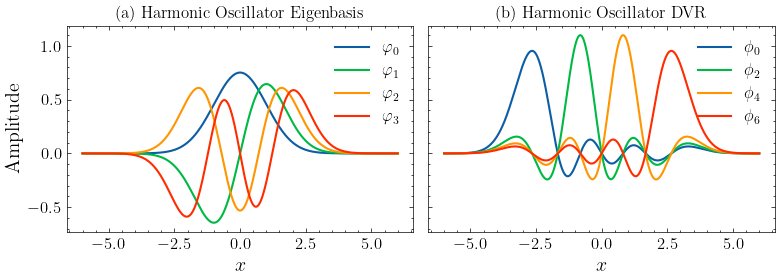

In [4]:
n_basis = 7
basis = BasisSHO(0, omega=omega, nbas=n_basis, dvr=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

plt.sca(axs[0])
for i in range(4):
    plt.plot(xi, psi_list[i], label=r"$\varphi_" + str(i) + "$")
plt.title("(a) Harmonic Oscillator Eigenbasis")
plt.xlabel("$x$")
plt.ylabel("Amplitude")
plt.legend()

plt.sca(axs[1])
for i in range(n_basis):
    phi = basis.dvr_v[:, i] @ np.array(psi_list)[:n_basis]
    # adjust the phase for clarity
    if phi[np.argmax(np.abs(phi))] < 0:
        phi = -phi
    if i % 2 == 0:
        plt.plot(xi, phi, label=r"$\phi_" + str(i) + "$")
        
plt.title("(b) Harmonic Oscillator DVR")
plt.xlabel("$x$")
plt.legend()

plt.tight_layout()
plt.savefig("sho.pdf")
plt.show()

## Variational calculation
We variationally calculate of the ground state energy and wavefunction of a displaced harmonic oscillator using the ``BasisSHO`` basis set.
The Hamiltonian is written as

$$
H = -\frac{1}{2m}\frac{d^2}{dx^2} + \frac{1}{2} m\omega^2 (x-x_{\textrm{eq}})^2
$$

In second-quantization, it is written as

$$
H =\omega b^\dagger b + g\omega(b^\dagger + b) + E_{\textrm{shift}}
$$

where $g=-\sqrt{\frac{m\omega}{2}} x_{\textrm{eq}}$ and $E_{\textrm{shift}}=\frac{1}{2}m\omega^2x_{\textrm{eq}}^2+\frac{1}{2}\omega$ are constants.

We label the DOF of this nuclear coordiate as ``0``, and construct the Hamiltonian using the ``Op`` class.
The Hamiltonian matrix is calculated by constructing an MPO with only 1 site.

We perform the calculation at several different values of $x_{\textrm{eq}}$ and the number of basis in the basis set.

In [5]:
e_list = []
wfn_list = []
nbas_list = [4, 8, 16]
x_eq_range = np.linspace(1, 3, 10)
for n_basis in nbas_list:
    e_list.append([])
    for x_eq in x_eq_range:
        g = -np.sqrt(omega/2) * x_eq
    
        ham = omega * Op(r"b^\dagger b", 0) + g * omega * Op("b^\dagger+b", 0)
        constant = omega / 2 + omega ** 2 * x_eq ** 2 / 2
        
        basis = [BasisSHO(0, nbas=n_basis, omega=omega)]
        model = Model(basis, ham)
        h = Mpo(model).todense()
        evals, evecs = np.linalg.eigh(h)
        e = evals[0]
        e_list[-1].append(e + constant)
        if x_eq == x_eq_range[-1]:
            wfn_list.append(evecs[:, 0])

When $x_{\textrm{eq}}$ is small, say 1, we see that using 4 basis states are enough for accurate result.
However, when $x_{\textrm{eq}}$ increases to around 3, using 4 basis states has a large error.
If we employ 16 basis states instead, the error is suppressed. 
We expect that even more states will be required if $x_{\textrm{eq}}$ continues to increase.

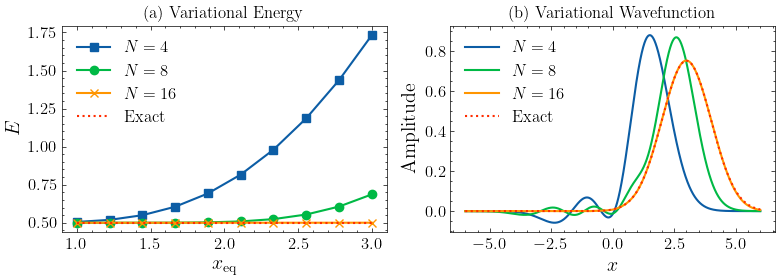

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plt.sca(axs[0])

labels = [f"$N={i}$" for i in nbas_list]
markers = ["s", "o", "x"]
for i in range(3):
    plt.plot(x_eq_range, e_list[i], label=labels[i], marker=markers[i])
plt.plot(x_eq_range, np.ones(len(x_eq_range)) * 0.5, label="Exact", linestyle=":")
plt.xlabel(r"$x_{\textrm{eq}}$")
plt.ylabel("$E$")
plt.title("(a) Variational Energy")
plt.legend()

plt.sca(axs[1])
for i in range(3):
    phi =  wfn_list[i] @ psi_list[:nbas_list[i]]
    if phi[np.argmax(np.abs(phi))] < 0:
        phi = -phi
    plt.plot(xi, phi, label=labels[i])
n = np.sqrt(1/(np.pi**0.5))
plt.plot(xi, n * hermite(0, xi-3) * np.exp(-(xi-3) ** 2/ 2), linestyle=":", label="Exact")
plt.xlabel("$x$")
plt.ylabel("Amplitude")
plt.title("(b) Variational Wavefunction")
plt.legend()

plt.tight_layout()
plt.savefig("sho_variational.pdf")
plt.show()